In [1]:
import math
import functools
import numpy as np
import scipy as sci
import matplotlib.pyplot as plt
import qutip as qt
import time
from scipy.integrate import ode

In [4]:
# This dictionary maps string keys ('x', 'y', 'z', 'p', 'm', 'i') to functions that generate spin operators for a given dimension dim.
opstr2fun = {'x': lambda dim: qt.spin_Jx((dim-1)/2),
             'y': lambda dim: qt.spin_Jy((dim-1)/2),
             'z': lambda dim: qt.spin_Jz((dim-1)/2),
             'p': lambda dim: qt.spin_Jp((dim-1)/2),
             'm': lambda dim: qt.spin_Jm((dim-1)/2),
             'i': qt.identity}
# Initializes ops as a list of identity matrices for each dimension in dims. Iterates over specs to replace the identity matrix at the specified index with the corresponding spin operator. Returns the tensor product of the operators in ops using qt.tensor.
def mkSpinOp(dims, specs):
    ops = [qt.identity(d) for d in dims]
    for ind, opstr in specs:
        ops[ind] = ops[ind] * opstr2fun[opstr](dims[ind])
    return qt.tensor(ops)
# Constructs a Hamiltonian for a single spin system with interactions along the x, y, and z axes.
def mkH1(dims, ind, parvec):
    axes = ['x', 'y', 'z']
    # Creates a list of spin operators weighted by the corresponding parameters in parvec (ignores zero parameters). Uses functools.reduce to sum these weighted spin operators.
    return functools.reduce(lambda a, b: a + b, 
               [v * mkSpinOp(dims, [(ind,ax)]) for v, ax in zip(parvec, axes) if v!=0])
# Constructs a Hamiltonian for the interaction between two spin systems with interaction terms along all combinations of x, y, and z axes.
def mkH12(dims, ind1, ind2, parmat):
    axes = ['x', 'y', 'z']
    ops = []
    # Iterates over all combinations of the x, y, and z axes for the two spins. For each non-zero element in parmat, adds the corresponding spin-spin interaction term to the empty list ops.
    for i in range(3):
        for j in range(3):
            if parmat[i,j] != 0:
                ops.append(parmat[i,j] * mkSpinOp(dims, [(ind1,axes[i]), (ind2,axes[j])]))
    return functools.reduce(lambda a, b: a + b, ops) # Uses functools.reduce to sum these interaction terms.

In [5]:
N5_C =  2*np.pi* np.array([[-0.36082693, -0.0702137 , -1.41518116],
      [-0.0702137 , -0.60153649,  0.32312139],
      [-1.41518116,  0.32312139, 50.80213093]]) # in MHz
	  
N1_C = 2*np.pi*np.array([[  2.13814981,   3.19255832,  -2.48895215],
      [  3.19255832,  15.45032887, -12.44778343],
      [ -2.48895215, -12.44778343,  12.49532827]]) # in MHz

N5_D =  2*np.pi*np.array([[-2.94412424e-01, -5.68059200e-02, -1.02860888e+00],
      [-5.68059200e-02, -5.40578469e-01, -2.67686240e-02],
      [-1.02860888e+00, -2.67686240e-02,  5.05815320e+01]]) # in MHz
	  
N1_D = 2*np.pi* np.array([[ 0.98491908,  3.28010265, -0.53784491],
      [ 3.28010265, 25.88547678, -1.6335986 ],
      [-0.53784491, -1.6335986 ,  1.41368001]]) # in MHz


ErC_Dee =  np.array([[ 26.47042689, -55.90357828,  50.1679204 ],
                            [-55.90357828, -20.86385225,  76.13493805],
                             [ 50.1679204,  76.13493805,  -5.60657464]]) # in Mrad/s



ErD_Dee = np.array([[ 11.08087889, -34.6687169,   12.14623706],
                            [-34.6687169,  -33.09039672,  22.36229081],
                            [ 12.14623706,  22.36229081,  22.00951783]]) #  in Mrad/s


In [8]:
# Function to sample points on a Fibonacci sphere
def fibonacci_sphere(samples):
    phi = np.pi * (3. - np.sqrt(5.))  # Golden angle in radians
    xyz = []
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # Radius at y
        theta = phi * i  # Golden angle increment
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        xyz.append([x, y, z])
    return np.array(xyz)

# Function to perform the simulation
def run_simulation(parameters):
    b0 = params['b0']
    krC = params['krC']
    krD = params['krD']
    kf = params['kf']
    kCD = params['kCD']
    kDC = params['kDC']
    dims = params['dims']
    num_samples = params['num_samples']
    
    # Generate orientations on a Fibonacci sphere
    oris = fibonacci_sphere(num_samples)
    
    # Convert Cartesian coordinates to latitude and longitude
    num_points = len(oris)
    lat = np.zeros(num_points)
    lon = np.zeros(num_points)

    for i in range(num_points):
        x, y, z = oris[i]
        lat[i] = np.arcsin(z) * (180 / np.pi)
        lon[i] = np.arctan2(y, x) * (180 / np.pi)

    dim = np.prod(dims)  # Total dimension of the composite system
    
    H_C_list = []
    H_D_list = []
    
    for orientation in oris:
        B0 = b0 * orientation  # Magnetic field vector along orientation

        # Compute Hamiltonians for each orientation
        Hzee = mkH1(dims, 0, B0) + mkH1(dims, 1, B0)  # Zeeman Hamiltonian for two spins
        Hhfc_C = mkH12(dims, 0, 2, N5_C) + mkH12(dims, 1, 3, N1_C)
        Hhfc_D = mkH12(dims, 0, 2, N5_D) + mkH12(dims, 1, 4, N1_D)
        Hdee_C = mkH12(dims, 0, 1, ErC_Dee)
        Hdee_D = mkH12(dims, 0, 1, ErD_Dee)
        H0_C = Hzee + Hhfc_C + Hdee_C  # Total Hamiltonian for component C
        H0_D = Hzee + Hhfc_D + Hdee_D  # Total Hamiltonian for component D
        
        # Append Hamiltonians to the list
        H_C_list.append(H0_C.data)
        H_D_list.append(H0_D.data)

    Ps = 1/4 * mkSpinOp(dims,[]) - mkH12(dims, 0, 1, np.identity(3))  # Singlet projection operator

    rho0_C = (Ps / Ps.tr()).full().flatten()  # Initial density matrix for singlet state
    rho0_D = np.zeros_like(rho0_C)
    initial_state = np.concatenate((rho0_C, rho0_D)).flatten()
    Ps = Ps.data

    def mesolve(t, combined_rho, P_s, HA, HB, dimA, dimB):
        # Reshape rho back to a matrix
        lenA = dimA * dimA
        lenB = dimB * dimB
        rhoA = combined_rho[:lenA].reshape((dimA, dimA))
        rhoB = combined_rho[lenB:].reshape((dimB, dimB))
        
        # Compute the derivative of rho
        drhoA_dt = -1j * (HA @ rhoA - rhoA @ HA) - krC*(P_s @ rhoA + rhoA @ P_s)/2 - (kCD+kf)*rhoA + kDC*rhoB
        drhoB_dt = -1j * (HB @ rhoB - rhoB @ HB) - krD*(P_s @ rhoB + rhoB @ P_s)/2 - (kDC+kf)*rhoB + kCD*rhoA
        
        # Flatten the derivative to a vector
        return np.concatenate((drhoA_dt.flatten(), drhoB_dt.flatten()))

    yr_c_list = []  # List to store singlet yield for component C
    yr_d_list = []  # List to store singlet yield for component D

    for H_C, H_D in zip(H_C_list, H_D_list):
        # Create the solver instance
        solver = ode(mesolve).set_integrator('zvode', atol=1e-12, rtol=1e-10, method='adams', order=12)
        solver.set_initial_value(initial_state, 0).set_f_params(Ps, H_C, H_D, dim, dim)
        
        t = [(0., 1., 0.)]
        dt = 0.001
        tmax = 12. / krC  # Maximum time in microseconds

        while solver.successful() and solver.t < tmax:
            rho = solver.integrate(solver.t + dt)
            rho_c = rho[:dim**2].reshape((dim, dim))
            rho_d = rho[dim**2:].reshape((dim, dim))
            t.append((solver.t, np.trace(Ps @ rho_c), np.trace(Ps @ rho_d)))

        # Convert lists to arrays
        tlist = np.array([x for x, y, z in t])
        ps_c = np.array([np.real(y) for x, y, z in t])
        ps_d = np.array([np.real(z) for x, y, z in t])
        
        # Compute yields
        yr_c = krC * sci.integrate.simps(ps_c , tlist)
        yr_d = krD * sci.integrate.simps(ps_d , tlist)
        
        yr_c_list.append(yr_c)
        yr_d_list.append(yr_d)

    # Plot results
    plotlat = lat.tolist()
    plotlon = lon.tolist()
    plotyc = yr_c_list
    plotyd = yr_d_list

    plt.figure(figsize=(10, 5))

    # Contour plot for component C
    plt.subplot(1, 2, 1)
    plt.tricontourf(plotlon, plotlat, plotyc, levels=20, cmap='plasma')
    plt.colorbar(label='Singlet Yield C')
    plt.title("Yield vs. orientation (Component C)")
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")

    # Contour plot for component D
    plt.subplot(1, 2, 2)
    plt.tricontourf(plotlon, plotlat, plotyd, levels=20, cmap='plasma')
    plt.colorbar(label='Singlet Yield D')
    plt.xlabel("Longitude (deg)")
    plt.ylabel("Latitude (deg)")
    plt.title('Yield vs. orientation (Component D)')

    plt.tight_layout()
    plt.show()

    max_yield = max(plotyc)+max(plotyd)
    min_yield = min(plotyc)+min(plotyd)
    avg_yield = (sum(plotyc)+sum(plotyd))/(len(plotyc)+len(plotyd))
    compass_sensitivity = max_yield - min_yield 
    chi = compass_sensitivity / avg_yield 
    print('compass sensitivity = ', compass_sensitivity) 
    print('chi = ', chi)

/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_64892/625191982.py:104: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  yr_c = krC * sci.integrate.simps(ps_c , tlist)
/var/folders/_k/n00gvc8n0mn06wzz2y3rqqgh0000gp/T/ipykernel_64892/625191982.py:105: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  yr_d = krD * sci.integrate.simps(ps_d , tlist)


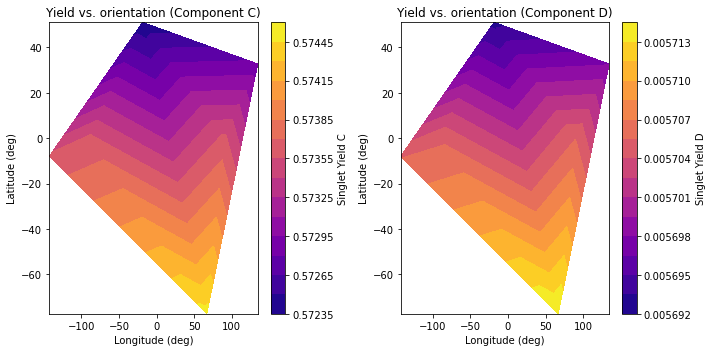

compass sensitivity =  0.002145730492242315
chi =  0.0074103470128874475


In [9]:
# Example dictionary of parameters
params = {
    'b0': 1.4 * 2 * np.pi,  # Zeeman field strength in radians per microsecond
    'krC': 10.,             # Rate constant 1/us
    'krD': 0.1,
    'kf': 1.,
    'kCD': 1e4,
    'kDC': 1e4,
    'dims': [2, 2, 3, 3, 3],  # Dimensions of system components (2 qubits, 1 spin-1 nucleus)
    'num_samples': 6,       # Number of samples on the Fibonacci sphere
}

# Call the function with parameters
run_simulation(params)